In [1]:
import os

import ase
from ase.visualize import view

import numpy as np
import matplotlib.pyplot as plt

from ppafm.io import loadXYZ

from molnet.data import input_pipeline_seg
from configs.tests import attention_test
from configs import root_dirs

 PACKAGE_PATH =  /m/home/home7/79/kurkil1/unix/git/ppafm/ppafm
 CPP_PATH     =  /m/home/home7/79/kurkil1/unix/git/ppafm/ppafm/cpp


2025-01-30 12:51:07.463807: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-30 12:51:07.465134: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-30 12:51:07.492628: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-30 12:51:07.493210: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-30 12:51:11.151788: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
scan_window = np.array(
    [
        [0.0, 0.0, 0.0],
        [16., 16., 0.0]
    ]
)

In [3]:
mol_folder = '/l/mol_database'
index = 1

fname = os.path.join(mol_folder, f'{index}.xyz')
xyz, zs, _, _ = loadXYZ(fname)

mol = ase.Atoms(positions=xyz, numbers=zs, cell=scan_window[1])
mol.center()
# Shift molecule so that top atom is at z=2
mol.positions[:, 2] += mol.positions[:, 2].min() + 2

In [14]:
def compute_segmentation_map(mol: ase.Atoms):
    """Segments the molecule into a 3D grid by atom type."""
    z_max = mol.get_positions()[:, 2].max()
    x = np.linspace(0., 16., 128)
    y = np.linspace(0., 16., 128)
    z = np.linspace(z_max, z_max-2, 20)

    X, Y, Z = np.meshgrid(x, y, z, indexing='xy')

    seg = np.zeros_like(X, dtype=int)

    for atom in mol:
        pos = atom.position
        #m = np.exp(
        #    -((X - pos[0])**2 + (Y - pos[1])**2 + (Z - pos[2])**2) / 0.2**2
        #)
        #m = np.where(m < 1e-2, 0, 1)

        m = (X - pos[0])**2 + (Y - pos[1])**2 + (Z - pos[2])**2
        m = np.where(m < 0.2, 1, 0)

        seg += m * atom.number

    return seg


In [15]:
seg = compute_segmentation_map(mol)
# print unique atom types
print(np.unique(seg))

[0 1 6 7 8]


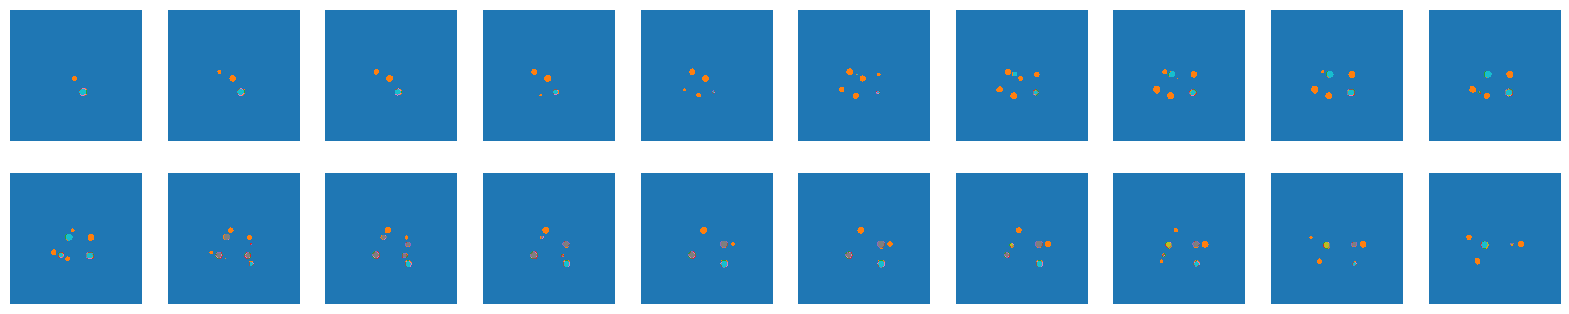

In [18]:
ncols = 10
nrows = seg.shape[-1] // ncols + 1

fig = plt.figure(figsize=(ncols * 2, nrows * 2))

for i in range(seg.shape[-1]):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(seg[:, :, i], cmap='tab10', origin='lower')
    plt.axis('off')

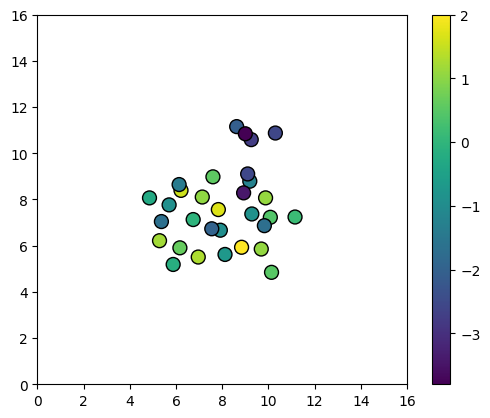

In [17]:
fig = plt.figure()
ax = plt.subplot(111)
im = ax.scatter(mol.positions[:, 0], mol.positions[:, 1], c=mol.positions[:, 2], s=100, cmap='viridis', edgecolors='k')
plt.colorbar(im)

ax.set_xlim(0, 16)
ax.set_ylim(0, 16)
ax.set_aspect('equal')

In [ ]:
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.voxels(seg > 0, facecolors='white', edgecolor='k')
ax.set_aspect('equal')
plt.show()

In [9]:
view(mol)

<Popen: returncode: None args: ['/u/79/kurkil1/unix/.venvs/tf-2.13/bin/pytho...>

In [34]:
config = attention_test.get_config()
config.train_molecules = (0, 100000)
config.val_molecules = (100000, 120000)
config.rng_seed = 0
config.dataset = "afms_rebias"
config.root_dir = root_dirs.get_root_dir(config.dataset)
config.num_workers = 8
config.batch_size = 1
config.interpolate_input_z = 20
config.sigma = 0.2
config.target_z_cutoff = 2.0
config.noise_std = 0.2

In [36]:
ds = input_pipeline_seg.get_datasets(config)['train']
batch = next(ds)

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 18085879115725111131
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 8929706196777782978
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing t

In [37]:
y = batch['atom_map']

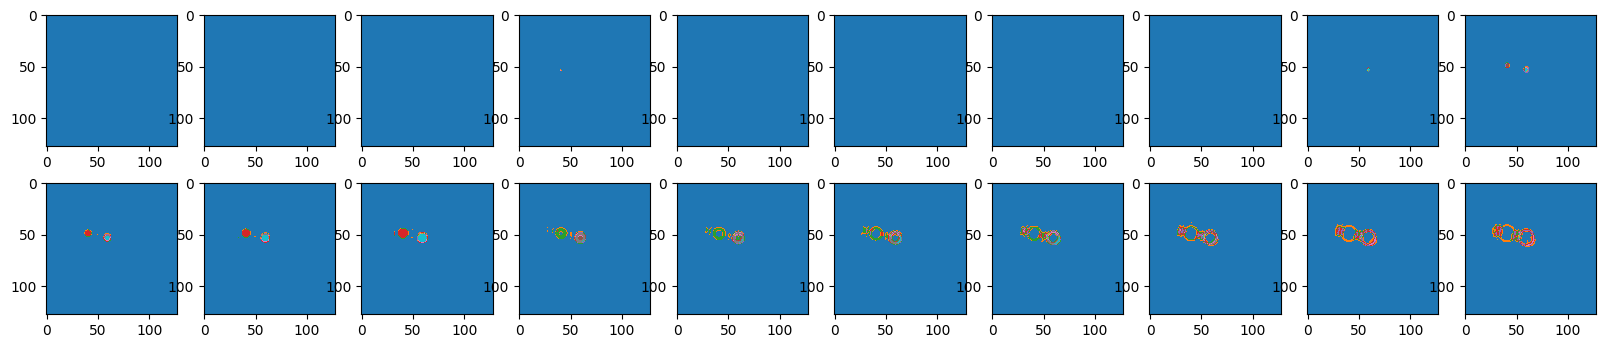

In [49]:
fig = plt.figure(figsize=(20, 4))
for i in range(y.shape[-1]):
    ax = plt.subplot(2, 10, i + 1)
    ax.imshow(y[0, :, :, i], cmap='tab10')
